In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
df = pd.read_csv('ESH22-900-ESH22.csv')

In [8]:
print(df.head())

   PROGRESSIVO  OPEN(H)  HIGH(H)   LOW(H)  CLOSE(H)        Entry Date  \
0            1  1035.50  1044.25  1034.00   1039.75  16/01/1998 14:45   
1            2  1043.25  1056.75  1042.00   1056.00  20/01/1998 14:45   
2            3  1050.50  1053.50  1039.00   1044.50  21/01/1998 14:45   
3            4  1040.25  1045.50  1035.75   1039.75  22/01/1998 14:45   
4            5  1041.25  1044.00  1026.50   1032.00  23/01/1998 14:45   

            Market  
0  ESH22-900-ESH22  
1  ESH22-900-ESH22  
2  ESH22-900-ESH22  
3  ESH22-900-ESH22  
4  ESH22-900-ESH22  


In [4]:
df.isnull().sum()

PROGRESSIVO    0
OPEN(H)        0
HIGH(H)        0
LOW(H)         0
CLOSE(H)       0
Entry Date     0
Market         0
dtype: int64

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['OPEN(H)', 'HIGH(H)', 'LOW(H)', 'CLOSE(H)']])

In [6]:
def create_sequences(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 1
X, y = create_sequences(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

In [7]:
train_size = int(len(X) * 0.70)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = y[0:train_size], y[train_size:len(y)]

In [8]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
model.fit(trainX, trainY, epochs=20, batch_size=32)

Epoch 1/20

145/145 [==============================] - 2s 2ms/step - loss: 0.0102
Epoch 2/20
145/145 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 3/20
145/145 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 4/20
145/145 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 5/20
145/145 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/20
145/145 [==============================] - 0s 2ms/step - loss: 4.8515e-04
Epoch 7/20
145/145 [==============================] - 0s 2ms/step - loss: 1.4594e-04
Epoch 8/20
145/145 [==============================] - 0s 2ms/step - loss: 3.8002e-05
Epoch 9/20
145/145 [==============================] - 0s 2ms/step - loss: 1.8197e-05
Epoch 10/20
145/145 [==============================] - 0s 2ms/step - loss: 1.5865e-05
Epoch 11/20
145/145 [==============================] - 0s 2ms/step - loss: 1.5632e-05
Epoch 12/20
145/145 [==============================] - 0s 2ms/step - loss: 1.5574e

In [10]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

62/62 [==============================] - 0s 1ms/step


In [11]:

# Create a temporary array with the same shape as the scaled_data used to fit the scaler
temp_array = np.zeros((len(trainPredict), 4))
temp_array[:,0] = trainPredict[:,0]  # Copy predictions into the first column

# Inverse transform the temporary array
trainPredict_inverse = scaler.inverse_transform(temp_array)[:,0]

# Repeat the process for testPredict
temp_array = np.zeros((len(testPredict), 4))
temp_array[:,0] = testPredict[:,0]
testPredict_inverse = scaler.inverse_transform(temp_array)[:,0]

# If trainY is 1-dimensional, reshape it to 2-dimensional
trainY = trainY.reshape(-1, 1) if trainY.ndim == 1 else trainY
temp_array = np.zeros((len(trainY), 4))
temp_array[:,0] = trainY[:,0]
trainY_inverse = scaler.inverse_transform(temp_array)[:,0]

# Ensure testY is 2-dimensional
testY = testY.reshape(-1, 1) if testY.ndim == 1 else testY
temp_array = np.zeros((len(testY), 4))
temp_array[:,0] = testY[:,0]
testY_inverse = scaler.inverse_transform(temp_array)[:,0]

In [12]:
def mean_percentage_accuracy(y_true, y_pred):
    """
    Calculate the mean percentage accuracy.
    
    Parameters:
    - y_true: actual values
    - y_pred: predicted values
    
    Returns:
    - accuracy: mean percentage accuracy
    """
   
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    
  
    percentage_diff = np.abs((y_true - y_pred) / y_true) * 100
    
   
    accuracy = 100 - np.mean(percentage_diff)
    
    return accuracy

accuracy = mean_percentage_accuracy(testY_inverse, testPredict_inverse)
#prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 97.98%


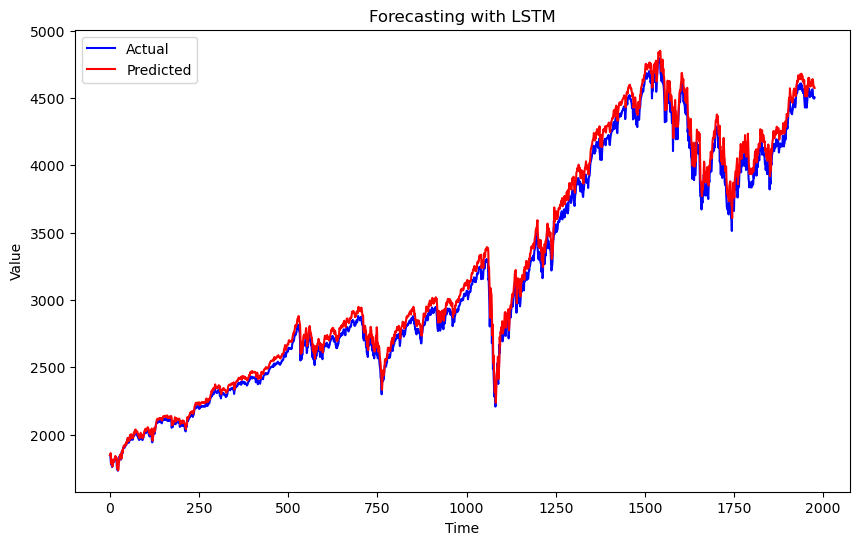

In [13]:

plt.figure(figsize=(10,6))
plt.plot(testY_inverse, color='blue', label='Actual')  # Use testY_inverse instead of y_test
plt.plot(testPredict_inverse, color='red', label='Predicted')  # Use testPredict_inverse instead of predictions
plt.title('Forecasting with LSTM')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [14]:
prediction = pd.DataFrame(testPredict_inverse, columns=['Predictions']).to_csv('OCLH_Predictions1.csv')
actual = pd.DataFrame(testY_inverse, columns=['Actual']).to_csv('OCLH_actual.csv')